In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
import datetime as dt

In [5]:
from IPython.display import display

# Introduction

In [11]:
indexes = ['nifty 50', 'nifty 100', 'nifty 200', 'nifty 500', 'nifty midcap 50', 'nifty midcap 100', 'nifty midcap 150',
           'nifty smallcap 50', 'nifty smallcap 100', 'nifty smallcap 250']

The Indices are Total Return Indices, which includes dividend payments for calculation of index value.

In [14]:
nifty = pd.read_excel(indexes[6]+'.xlsx', index_col='Date')
nifty.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3407 entries, 2011-01-03 to 2024-09-27
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Total Returns Index  3407 non-null   float64
 1   P/E                  2079 non-null   float64
 2   P/B                  2103 non-null   float64
 3   Div Yield            2103 non-null   float64
dtypes: float64(4)
memory usage: 133.1 KB


In [16]:
nifty.describe()

Total Returns Index          P/E          P/B    Div Yield
count          3407.000000  2079.000000  2103.000000  2103.000000
mean           8275.056120    45.929851     3.309857     0.984579
std            5891.558434    60.805806     0.728538     0.275631
min            2018.400000    18.240000     1.890000     0.440000
25%            3918.555000    26.945000     2.770000     0.830000
50%            7027.400000    33.670000     3.280000     0.970000
75%           11278.900000    42.885000     3.670000     1.155000
max           28421.390000   813.450000     5.620000     1.980000

In [18]:
nifty[nifty.duplicated(keep=False)]

Total Returns Index  P/E  P/B  Div Yield
Date                                                
2011-03-03              2538.27  NaN  NaN        NaN
2011-12-21              2045.22  NaN  NaN        NaN
2011-12-28              2045.22  NaN  NaN        NaN
2012-12-05              2939.68  NaN  NaN        NaN
2013-02-01              2939.68  NaN  NaN        NaN
2013-09-20              2538.27  NaN  NaN        NaN

In [20]:
nifty.isna().sum()

Total Returns Index       0
P/E                    1328
P/B                    1304
Div Yield              1304
dtype: int64

Cumulative Annual Growth Rate calculation

In [62]:
def cagr_calc(df, start, end):
    
    if not isinstance(start, dt.datetime):
        start  = dt.datetime(*start)
    if start < dt.datetime(2011,1,1) or start > df.index[-1]:
        return print(f"start value should be between {df.index[0].date()} and {df.index[-1].date()}")
    
    initial_value = None
    while not initial_value:
        try:
            initial_value = df.loc[start]['Total Returns Index']
        except KeyError:
            start += dt.timedelta(days=1)

    
    if not isinstance(end, dt.datetime):
        end  = dt.datetime(*end)
    
    if end < df.index[0]:
        return print(f"end value should be greater than {df.index[0].date()}")

    if start > end:
        return print("start date shouldn't be greater than end date")
    
    final_value = None
    while not final_value:
        try:
            final_value = df.loc[end]['Total Returns Index']
        except KeyError:
            end -= dt.timedelta(days=1)
        
    r = (df.loc[end]['Total Returns Index']/df.loc[start]['Total Returns Index'])**(1/((end-start).days/365))-1

    return round(r*100, 2), f'between {start.date()} and {end.date()}'

In [66]:
cagr = cagr_calc(nifty, (2024,1,1), (2024,9,29))
cagr

(43.76, 'between 2024-01-01 and 2024-09-27')

# Data Visualization

In [70]:
nifty['day'] = nifty.index.day_name()
nifty.groupby(nifty['day']).count()

Total Returns Index  P/E  P/B  Div Yield
day                                                
Friday                     673  413  417        417
Monday                     677  409  414        414
Saturday                    12    5    5          5
Sunday                       4    3    3          3
Thursday                   678  419  424        424
Tuesday                    681  412  417        417
Wednesday                  682  418  423        423

<Axes: xlabel='None'>

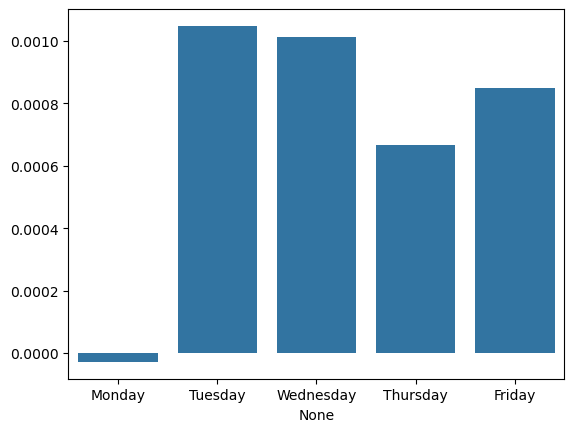

In [72]:
dd = nifty['Total Returns Index'].pct_change().groupby(nifty['day']).mean()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dd.index = pd.Categorical(dd.index, categories=days[:5], ordered=True)
sns.barplot(x=dd.index, y=dd.values)

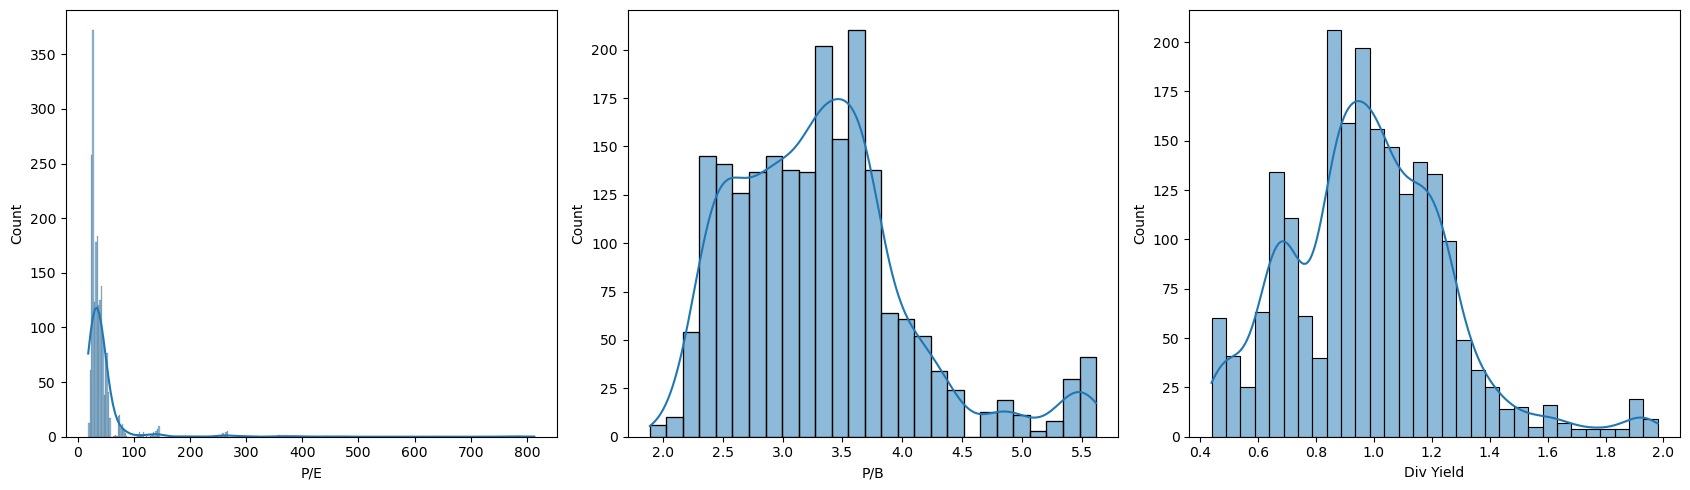

In [74]:
fig, axes = plt.subplots(1,3, figsize=(17,5))
for i, ax in enumerate(axes):
    sns.histplot(nifty[nifty.columns[i+1]], ax=ax, kde=True)
plt.tight_layout()

In [76]:
(nifty['Total Returns Index'].pct_change() > 0).sum() / nifty['Total Returns Index'].pct_change().count()

0.5833822665883734

<Axes: xlabel='Total Returns Index', ylabel='Count'>

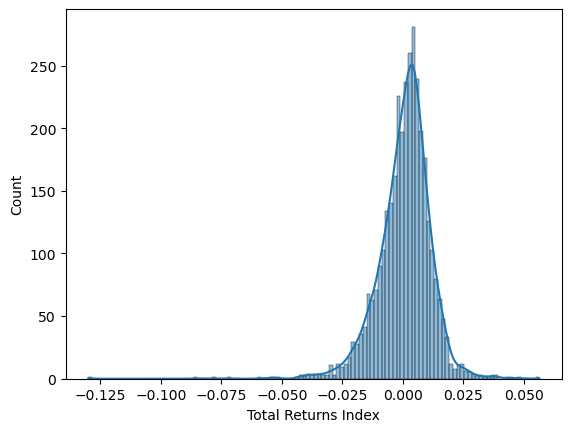

In [78]:
sns.histplot(nifty['Total Returns Index'].pct_change(), kde=True)

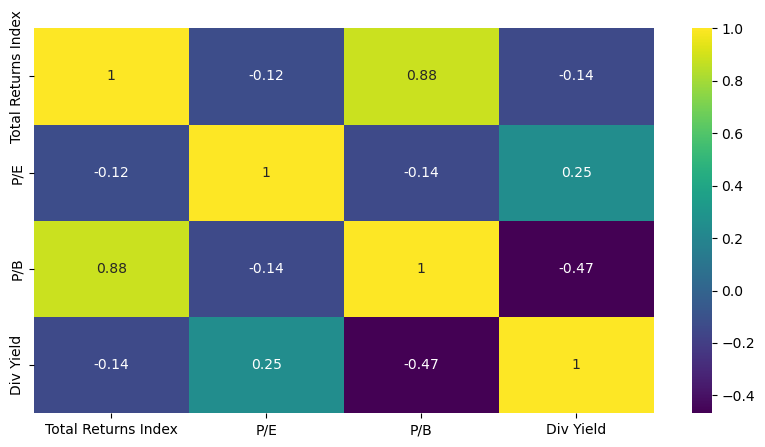

In [82]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(data=nifty[1000:].corr(numeric_only=True), annot=True, cmap='viridis')

In [84]:
nifty[(nifty['P/E'] > 200)].count()

Total Returns Index    47
P/E                    47
P/B                    47
Div Yield              47
day                    47
dtype: int64

In [86]:
nifty.loc[nifty[(nifty['P/E'] > 200)].index, 'P/E'] = np.nan

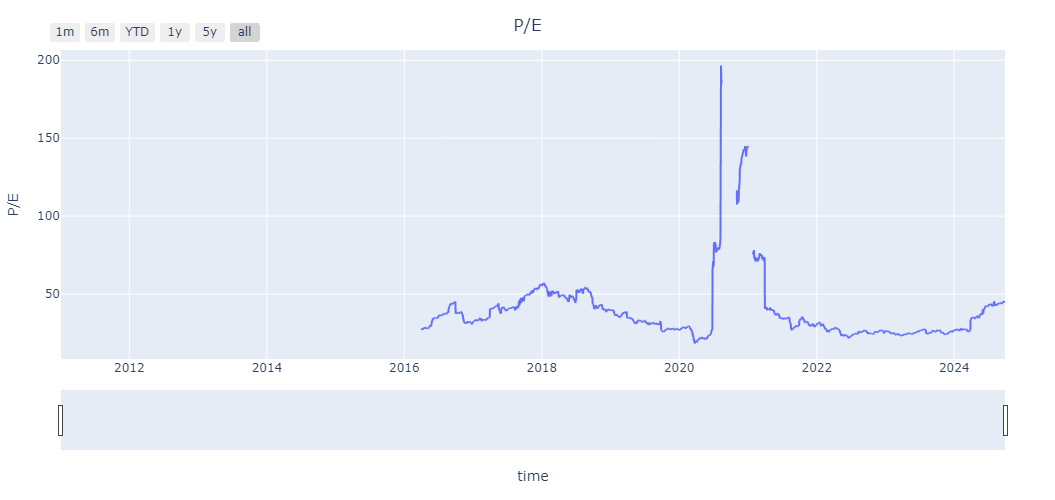

In [88]:
fig = px.line(nifty, x=nifty.index, y="P/E", title='P/E', height=500)
fig.update_layout(
    title={'text': "P/E", 'x':0.5, 'y':0.95, 'xanchor':'center', 'yanchor':'middle'},  xaxis_title='time', yaxis_title='P/E', margin=dict(l=50, r=50, b=50, t=50))
fig.update_xaxes(rangeslider_visible=True, 
                 rangeselector=dict(buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])))

fig.show()

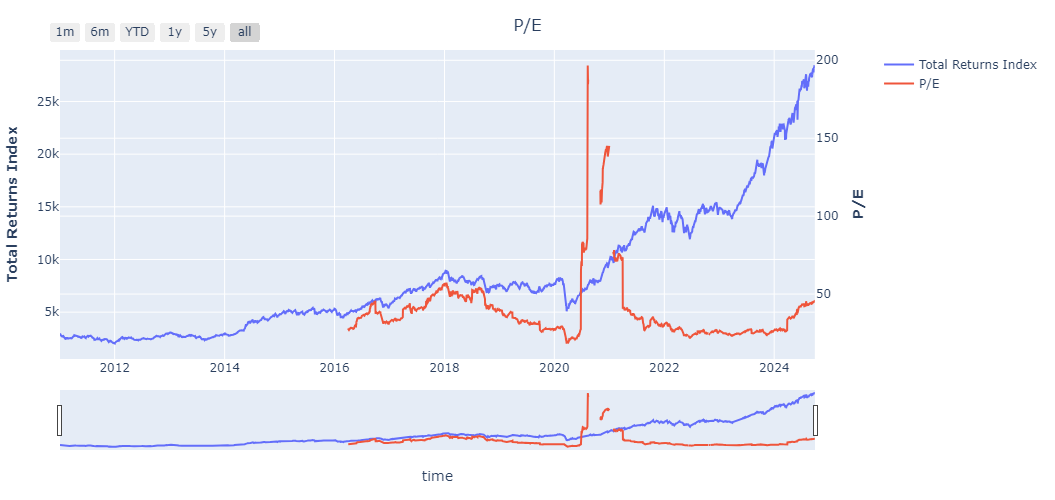

In [90]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["Total Returns Index"], name='Total Returns Index'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/E"], name='P/E'), secondary_y=True)
fig.update_layout(
    title={'text': "P/E", 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
fig.update_yaxes(title_text="<b>Total Returns Index</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>P/E</b>", secondary_y=True)
fig.show()

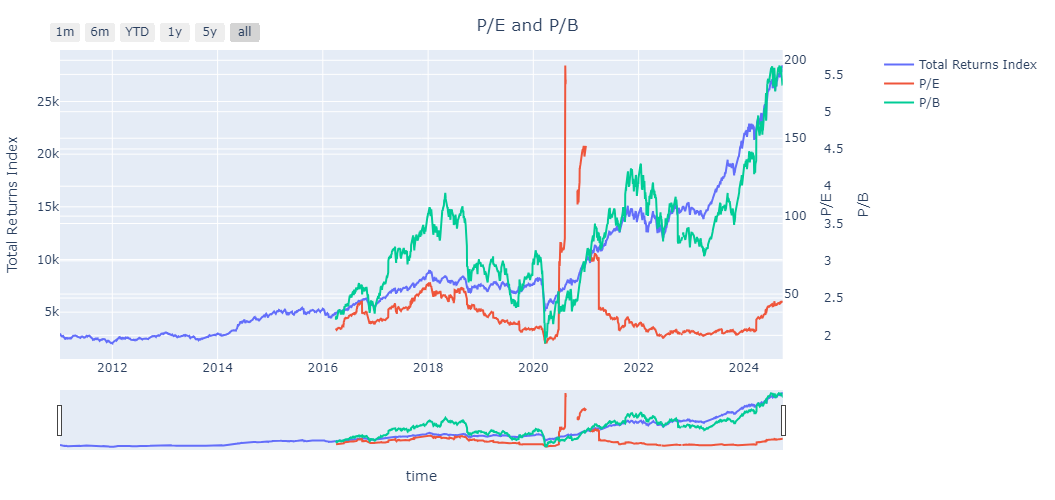

In [92]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=nifty.index, y=nifty["Total Returns Index"], name='Total Returns Index'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/E"], name='P/E', yaxis='y2'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/B"], name='P/B', yaxis='y3'))

fig.update_layout(xaxis=dict(domain=[0.0, 0.9]),
                  yaxis=dict(title="Total Returns Index"), yaxis2=dict(title = 'P/E', anchor="x", overlaying="y", side="right"),
                  yaxis3=dict(title = 'P/B', anchor="free", overlaying="y", side="right", position=.95),
    title={'text': "P/E and P/B", 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)

fig.update_xaxes(rangeslider_visible=True, 
                 rangeselector=dict(buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=5, label="5y", step="year", stepmode="backward"),
                    dict(step="all")])))

fig.show()

# yealy returns

In [95]:
np.unique(nifty.index.year, return_counts=True)

(array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023, 2024]),
 array([247, 251, 250, 244, 248, 248, 248, 246, 245, 252, 248, 248, 246,
        186], dtype=int64))

In [101]:
for i in range(14):
    print(nifty.index[i*249])

2011-01-03 00:00:00
2012-01-04 00:00:00
2013-01-01 00:00:00
2013-12-31 00:00:00
2015-01-07 00:00:00
2016-01-08 00:00:00
2017-01-10 00:00:00
2018-01-10 00:00:00
2019-01-15 00:00:00
2020-01-21 00:00:00
2021-01-18 00:00:00
2022-01-19 00:00:00
2023-01-19 00:00:00
2024-01-23 00:00:00


In [103]:
nifty_yearly = pd.DataFrame()

In [105]:
nifty_yearly['last 1 year returns'] = nifty['Total Returns Index'].pct_change(periods=249)

In [107]:
nifty_yearly['last 2 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*2)

In [109]:
nifty_yearly['last 3 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*3)

In [111]:
nifty_yearly['last 4 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*4)

In [113]:
nifty_yearly['last 5 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*5)

In [115]:
nifty_yearly['next 1 year returns'] = nifty_yearly['last 1 year returns'].shift(periods=-249)

In [117]:
nifty_yearly['next 2 year returns'] = nifty_yearly['last 2 year returns'].shift(periods=-249*2)

In [119]:
nifty_yearly['next 3 year returns'] = nifty_yearly['last 3 year returns'].shift(periods=-249*3)

In [121]:
nifty_yearly['next 4 year returns'] = nifty_yearly['last 4 year returns'].shift(periods=-249*4)

In [123]:
nifty_yearly['next 5 year returns'] = nifty_yearly['last 5 year returns'].shift(periods=-249*5)

In [125]:
nifty_yearly = nifty_yearly*100

In [127]:
nifty_with_returns = pd.concat([nifty, nifty_yearly], axis=1)

In [129]:
nifty_with_returns

Total Returns Index    P/E   P/B  Div Yield        day  \
Date                                                                 
2011-01-03              2980.82    NaN   NaN        NaN     Monday   
2011-01-04              2973.44    NaN   NaN        NaN    Tuesday   
2011-01-05              2931.29    NaN   NaN        NaN  Wednesday   
2011-01-06              2894.41    NaN   NaN        NaN   Thursday   
2011-01-07              2820.82    NaN   NaN        NaN     Friday   
...                         ...    ...   ...        ...        ...   
2024-09-23             28333.18  45.26  5.37       0.68     Monday   
2024-09-24             28421.39  45.40  5.39       0.68    Tuesday   
2024-09-25             28249.45  45.13  5.36       0.69  Wednesday   
2024-09-26             28262.65  45.15  5.36       0.68   Thursday   
2024-09-27             28253.79  45.13  5.36       0.69     Friday   

            last 1 year returns  last 2 year returns  last 3 year returns  \
Date                                                                        
2011-01-03                  NaN                  NaN                  NaN   
2011-01-04                  NaN                  NaN                  NaN   
2011-01-05                  NaN                  NaN                  NaN   
2011-01-06                  NaN                  NaN                  NaN   
2011-01-07                  NaN                  NaN                  NaN   
...                         ...                  ...                  ...   
2024-09-23            50.448640            87.303652           108.162920   
2024-09-24            51.071294            89.195042           107.752928   
2024-09-25            49.365646            87.427764           103.586874   
2024-09-26            49.527150            91.571184           101.079509   
2024-09-27            48.369156            97.362267           102.394815   

            last 4 year returns  last 5 year returns  next 1 year returns  \
Date                                                                        
2011-01-03                  NaN                  NaN           -29.713300   
2011-01-04                  NaN                  NaN           -29.428877   
2011-01-05                  NaN                  NaN           -28.591849   
2011-01-06                  NaN                  NaN           -27.268424   
2011-01-07                  NaN                  NaN           -24.865465   
...                         ...                  ...                  ...   
2024-09-23           247.368060           307.406694                  NaN   
2024-09-24           248.982205           314.844791                  NaN   
2024-09-25           259.076552           290.327024                  NaN   
2024-09-26           265.332239           280.149221                  NaN   
2024-09-27           266.577186           281.956110                  NaN   

            next 2 year returns  next 3 year returns  next 4 year returns  \
Date                                                                        
2011-01-03             1.499587            -0.976241            59.458136   
2011-01-04             2.241848            -0.187998            62.762995   
2011-01-05             4.353715            -0.703103            65.296508   
2011-01-06             6.109017             1.003659            68.264690   
2011-01-07             8.877915             4.099163            72.749059   
...                         ...                  ...                  ...   
2024-09-23                  NaN                  NaN                  NaN   
2024-09-24                  NaN                  NaN                  NaN   
2024-09-25                  NaN                  NaN                  NaN   
2024-09-26                  NaN                  NaN                  NaN   
2024-09-27                  NaN                  NaN                  NaN   

            next 5 year returns  
Date                             
2011-01-03            74.82

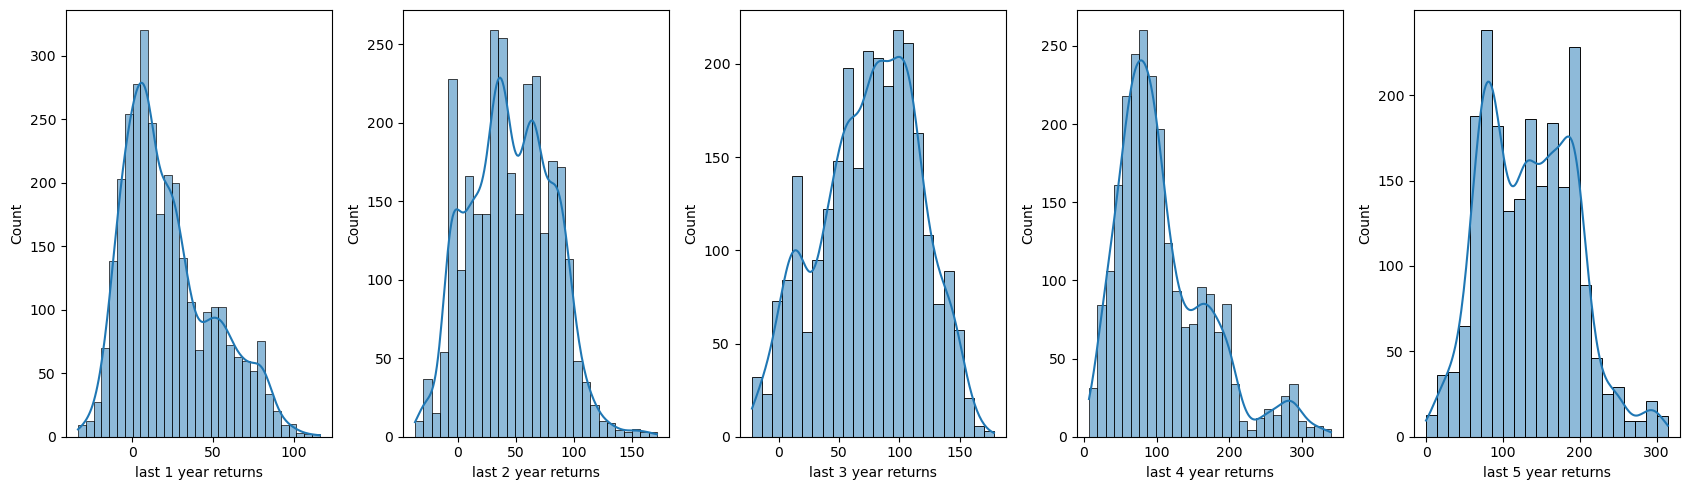

In [131]:
fig, axes = plt.subplots(1,5, figsize=(17,5))
for i, ax in enumerate(axes):
    sns.histplot(nifty_yearly.iloc[:,i], ax=ax, kde=True)
plt.tight_layout()

yearly correlations between returns and metric

In [134]:
nifty['Total Returns Index'].count()

3407

In [136]:
for i in range(0, nifty['Total Returns Index'].count(), 249):
    print(f"On {nifty.index[i].date()} next 1 year returns are {round(nifty_yearly['next 1 year returns'].iloc[i], 2)} and correlation between P/B and returns is {round(nifty['P/B'].iloc[i:i+249].corr(nifty_yearly['next 1 year returns'].iloc[i:i+249]),2)}")

On 2011-01-03 next 1 year returns are -29.71 and correlation between P/B and returns is nan
On 2012-01-04 next 1 year returns are 44.41 and correlation between P/B and returns is nan
On 2013-01-01 next 1 year returns are -2.44 and correlation between P/B and returns is nan
On 2013-12-31 next 1 year returns are 61.03 and correlation between P/B and returns is nan
On 2015-01-07 next 1 year returns are 9.64 and correlation between P/B and returns is nan
On 2016-01-08 next 1 year returns are 11.09 and correlation between P/B and returns is -0.73
On 2017-01-10 next 1 year returns are 53.34 and correlation between P/B and returns is -0.94
On 2018-01-10 next 1 year returns are -14.64 and correlation between P/B and returns is -0.75
On 2019-01-15 next 1 year returns are 6.17 and correlation between P/B and returns is -0.34
On 2020-01-21 next 1 year returns are 23.41 and correlation between P/B and returns is -0.94
On 2021-01-18 next 1 year returns are 47.55 and correlation between P/B and retu

In [138]:
nifty['P/E'].iloc[:1000].corr(nifty_yearly['next 1 year returns'].iloc[:1000])

nan

In [140]:
nifty['P/E'].iloc[1000:].corr(nifty_yearly['next 1 year returns'].iloc[1000:])

0.0012596910196869563

In [142]:
nifty['Div Yield'].corr(nifty_yearly['next 1 year returns'])

0.7019125175307479

In [144]:
def compare_three(y1, y2, y3):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y1], name=y1))
    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y2], name=y2, yaxis='y2'))
    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y3], name=y3, yaxis='y3'))

    fig.update_layout(xaxis=dict(domain=[0.0, 0.9]),
                      yaxis=dict(title=y1), 
                      yaxis2=dict(title = y2, anchor="x", overlaying="y", side="right"),
                      yaxis3=dict(title = y3, anchor="free", overlaying="y", side="right", position=.95),
        title={'text': y1+' '+y2+' '+y3, 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)

    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(rangeslider_visible=True, 
                     rangeselector=dict(buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=5, label="5y", step="year", stepmode="backward"),
                        dict(step="all")])))
    fig.show()

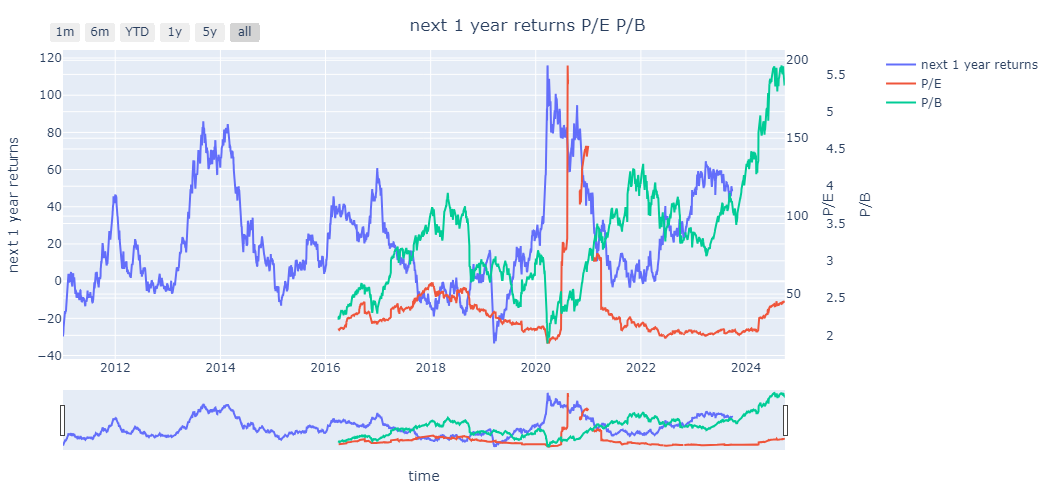

In [146]:
compare_three('next 1 year returns', 'P/E', 'P/B')

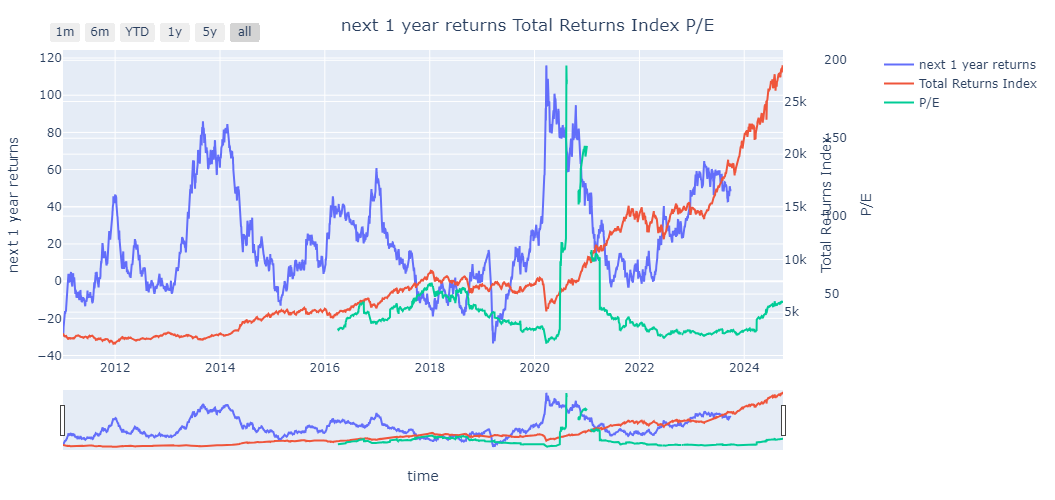

In [148]:
compare_three('next 1 year returns', 'Total Returns Index', 'P/E')

<Axes: >

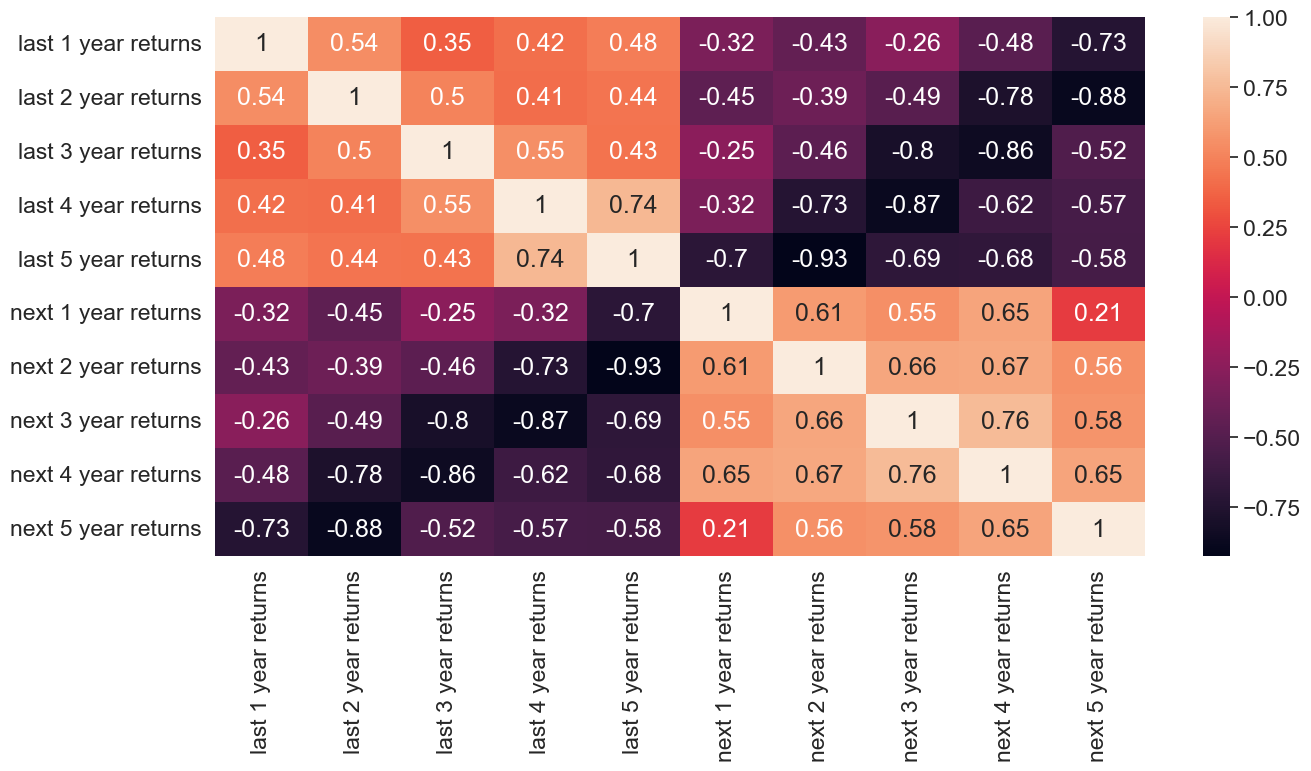

In [150]:
plt.figure(figsize = (15,7))
sns.set(font_scale=1.5)
sns.heatmap(nifty_yearly.corr(), annot=True)

In [152]:
nifty_with_returns.iloc[1000:, :]

Total Returns Index    P/E   P/B  Div Yield        day  \
Date                                                                 
2015-01-13              4872.94    NaN   NaN        NaN    Tuesday   
2015-01-14              4866.13    NaN   NaN        NaN  Wednesday   
2015-01-15              4919.06    NaN   NaN        NaN   Thursday   
2015-01-16              4943.40    NaN   NaN        NaN     Friday   
2015-01-19              4957.59    NaN   NaN        NaN     Monday   
...                         ...    ...   ...        ...        ...   
2024-09-23             28333.18  45.26  5.37       0.68     Monday   
2024-09-24             28421.39  45.40  5.39       0.68    Tuesday   
2024-09-25             28249.45  45.13  5.36       0.69  Wednesday   
2024-09-26             28262.65  45.15  5.36       0.68   Thursday   
2024-09-27             28253.79  45.13  5.36       0.69     Friday   

            last 1 year returns  last 2 year returns  last 3 year returns  \
Date                                                                        
2015-01-13            65.946636            58.663085           129.919647   
2015-01-14            66.484084            58.316605           124.245622   
2015-01-15            67.691416            60.696878           124.129510   
2015-01-16            69.553496            62.252645           123.617488   
2015-01-19            71.520354            65.194081           122.724945   
...                         ...                  ...                  ...   
2024-09-23            50.448640            87.303652           108.162920   
2024-09-24            51.071294            89.195042           107.752928   
2024-09-25            49.365646            87.427764           103.586874   
2024-09-26            49.527150            91.571184           101.079509   
2024-09-27            48.369156            97.362267           102.394815   

            last 4 year returns  last 5 year returns  next 1 year returns  \
Date                                                                        
2015-01-13            72.749059                  NaN             2.810418   
2015-01-14            76.759282                  NaN            -0.031442   
2015-01-15            79.377819                  NaN            -4.246746   
2015-01-16            76.970304                  NaN            -3.235020   
2015-01-19            79.325250                  NaN            -5.407466   
...                         ...                  ...                  ...   
2024-09-23           247.368060           307.406694                  NaN   
2024-09-24           248.982205           314.844791                  NaN   
2024-09-25           259.076552           290.327024                  NaN   
2024-09-26           265.332239           280.149221                  NaN   
2024-09-27           266.577186           281.956110                  NaN   

            next 2 year returns  next 3 year returns  next 4 year returns  \
Date                                                                        
2015-01-13            20.645647            79.518114            53.017480   
2015-01-14            21.243370            81.051061            53.039068   
2015-01-15            20.656589            76.121861            51.046541   
2015-01-16            20.651374            77.107254            49.864870   
2015-01-19            18.575558            77.705901            47.460157   
...                         ...                  ...                  ...   
2024-09-23                  NaN                  NaN                  NaN   
2024-09-24                  NaN                  NaN                  NaN   
2024-09-25                  NaN                  NaN                  NaN   
2024-09-26                  NaN                  NaN                  NaN   
2024-09-27                  NaN                  NaN                  NaN   

            next 5 year returns  
Date                             
2015-01-13            67.91

<Axes: >

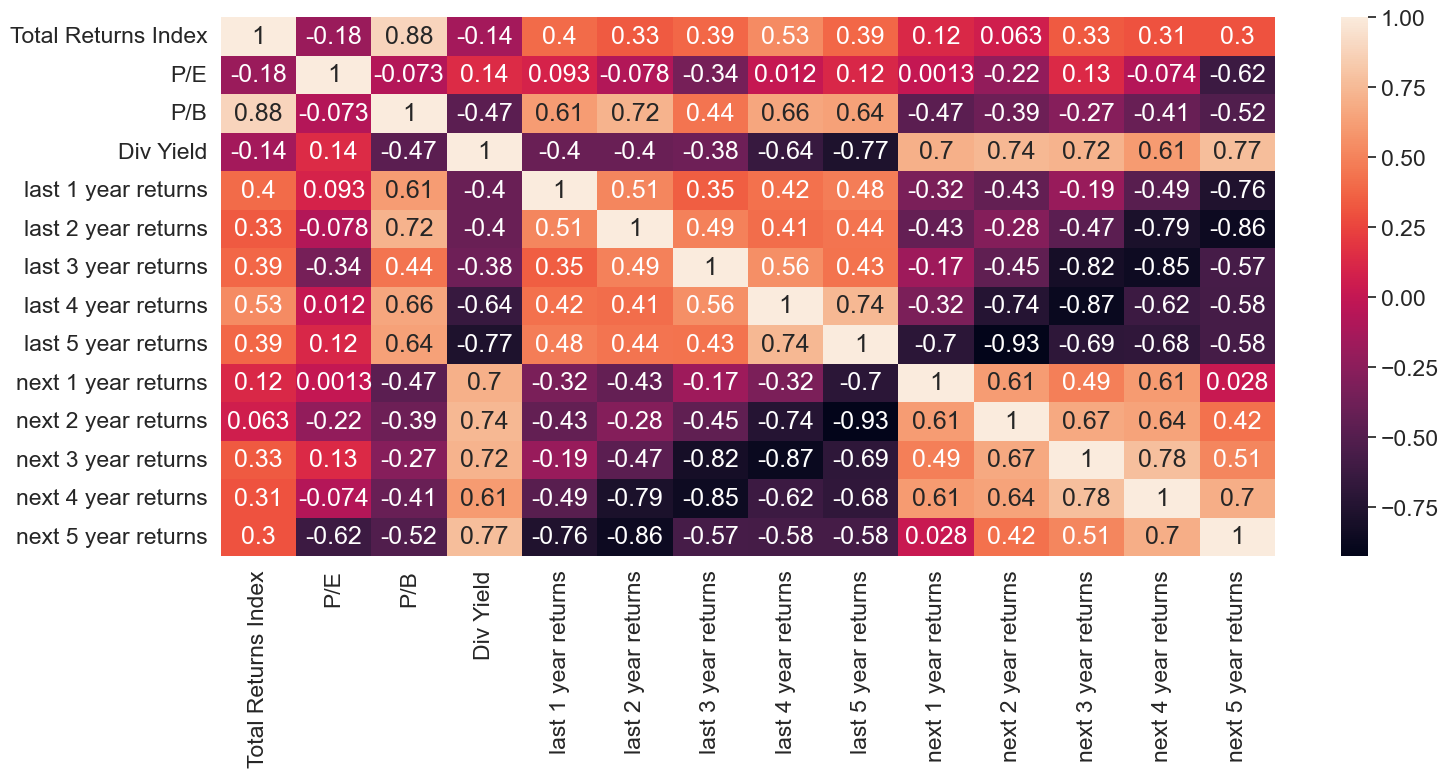

In [156]:
plt.figure(figsize = (17,7))
sns.set(font_scale=1.5)
sns.heatmap(nifty_with_returns.iloc[1000:, :].corr(numeric_only=True), annot=True)

# Linear Regression

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [67]:
data_set = nifty_with_returns[['P/E', 'P/B', 'Div Yield','next 1 year returns']]

In [68]:
X = data_set[1000:].dropna()[['P/E', 'P/B', 'Div Yield']]
Y = data_set[1000:].dropna()['next 1 year returns']

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=101)

In [70]:
model = LinearRegression()

In [71]:
model.fit(X_train, Y_train)

LinearRegression()

In [72]:
model.coef_

array([ -0.18109067, -48.38341258, -27.95624389])

In [73]:
model.score(X_test, Y_test)

0.5494868591151141

In [74]:
pred = model.predict(X_test)

<AxesSubplot:ylabel='next 1 year returns'>

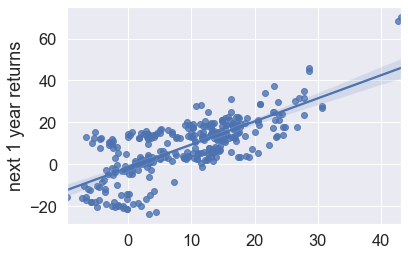

In [75]:
sns.regplot(x=pred, y=Y_test)

In [76]:
nifty.tail(1)

Total Returns Index    P/E   P/B  Div Yield     day
Date                                                           
2021-03-19             20956.87  40.16  4.18       1.08  Friday

In [77]:
nifty.tail(1).values[0][1:4]

array([40.16, 4.18, 1.08], dtype=object)

In [78]:
arr = nifty.tail(1).values[0][1:4]

In [79]:
model.predict(arr.reshape(1,-1))

array([-23.75737282])